# Credit Card Fraud Detection - Model Prototyping

This notebook experiments with different models and hyperparameters.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
import joblib

# For modeling
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            precision_recall_curve, auc, roc_curve, 
                            roc_auc_score, precision_score, recall_score,
                            f1_score, average_precision_score)
import xgboost as xgb
from imblearn.over_sampling import SMOTE

# For model explanation
import shap

# Suppress warnings
warnings.filterwarnings('ignore')

# Custom imports
import sys
sys.path.append('..')
from config.config import (PROCESSED_DATA_DIR, MODELS_DIR, RANDOM_STATE,
                          LOGISTIC_REGRESSION_PARAMS, RANDOM_FOREST_PARAMS, XGBOOST_PARAMS)

In [40]:
# Plot settings
plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Load Preprocessed Data

We'll load the preprocessed data that was saved in the previous notebook.

In [41]:
# Load preprocessed data
def load_data():
    X_train = np.load(PROCESSED_DATA_DIR / "X_train.npy")
    X_test = np.load(PROCESSED_DATA_DIR / "X_test.npy")
    y_train = np.load(PROCESSED_DATA_DIR / "y_train.npy")
    y_test = np.load(PROCESSED_DATA_DIR / "y_test.npy")
    
    # Also load original (non-SMOTE) training data for comparison
    X_train_orig = np.load(PROCESSED_DATA_DIR / "X_train_original.npy")
    y_train_orig = np.load(PROCESSED_DATA_DIR / "y_train_original.npy")
    
    return X_train, X_test, y_train, y_test, X_train_orig, y_train_orig

X_train, X_test, y_train, y_test, X_train_orig, y_train_orig = load_data()

print(f"Training set (SMOTE balanced): {X_train.shape[0]:,.0f} samples, {X_train.shape[1]} features")
print(f"Testing set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"Original training set: {X_train_orig.shape[0]:,.0f} samples")

# Check class distribution
print("\nClass distribution in balanced training set:")
print(pd.Series(y_train).value_counts())
print("\nClass distribution in original training set:")
print(pd.Series(y_train_orig).value_counts())
print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts())

Training set (SMOTE balanced): 454,902 samples, 30 features
Testing set: 56962 samples, 30 features
Original training set: 227,845 samples

Class distribution in balanced training set:
0    227451
1    227451
Name: count, dtype: int64

Class distribution in original training set:
0    227451
1       394
Name: count, dtype: int64

Class distribution in test set:
0    56864
1       98
Name: count, dtype: int64


## Model Evaluation Function

Let's define functions to evaluate and visualize model performance.

In [42]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a model's performance on the test set and print metrics.
    
    Args:
        model: Trained model
        X_test: Test features
        y_test: True test labels
        model_name: Name of the model for display
    
    Returns:
        Dictionary of evaluation metrics
    """
    # Get predictions
    start_time = time.time()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    predict_time = time.time() - start_time
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Print report
    print(f"Model: {model_name}")
    print(f"Prediction time: {predict_time:.4f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC Score: {auc_roc:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, label=f'AP = {avg_precision:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Return metrics
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc,
        'avg_precision': avg_precision,
        'predict_time': predict_time
    }

def plot_model_comparison(metrics_dict):
    """
    Plot comparison of multiple models based on their metrics.
    
    Args:
        metrics_dict: Dictionary with model names as keys and metrics dictionaries as values
    """
    # Create comparison dataframe
    comparison_df = pd.DataFrame(metrics_dict).T
    
    # Plot metrics comparison
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()
    
    metrics_to_plot = ['precision', 'recall', 'f1', 'auc_roc']
    titles = ['Precision', 'Recall', 'F1 Score', 'AUC-ROC']
    
    for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[i]
        comparison_df[metric].plot(kind='bar', ax=ax, color=sns.color_palette('Set2'))
        ax.set_title(title)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        
        # Add value labels
        for j, v in enumerate(comparison_df[metric]):
            ax.text(j, v + 0.02, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Display metrics table
    print("Model Performance Metrics:")
    return comparison_df[['precision', 'recall', 'f1', 'auc_roc', 'avg_precision', 'predict_time']]

## Train and Evaluate Models

We'll train and evaluate the following models:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. Gradient Boosting Classifier (Additional model for fraud detection)

Training models on SMOTE-balanced data...

Training logistic_regression...
Training completed in 0.94 seconds

Training random_forest...
Training on subsample: 50,000 samples (11.0% of full data)
Training completed in 13.37 seconds

Training xgboost...
Training on subsample: 50,000 samples (11.0% of full data)
Training completed in 0.33 seconds

Training gradient_boosting...
Training completed in 0.76 seconds

Evaluating logistic_regression...
Model: logistic_regression
Prediction time: 0.0035 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

AUC-ROC Score: 0.9698
Average Precision Score: 0.7249


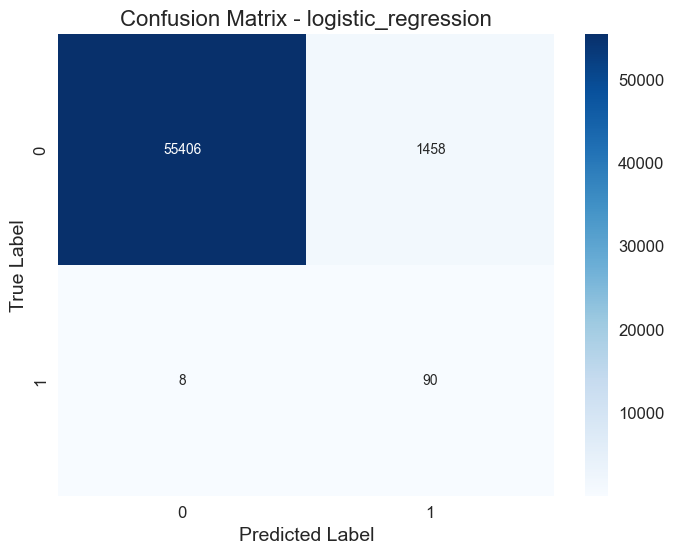

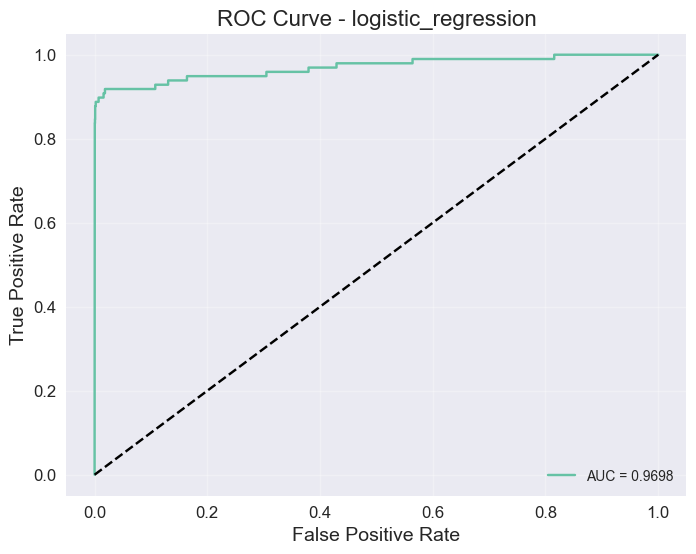

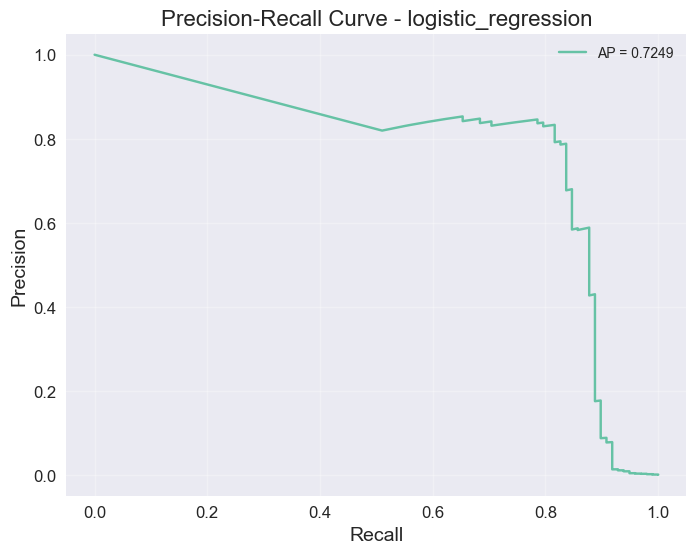



Evaluating random_forest...
Model: random_forest
Prediction time: 0.4094 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.39      0.89      0.54        98

    accuracy                           1.00     56962
   macro avg       0.69      0.94      0.77     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC Score: 0.9798
Average Precision Score: 0.7938


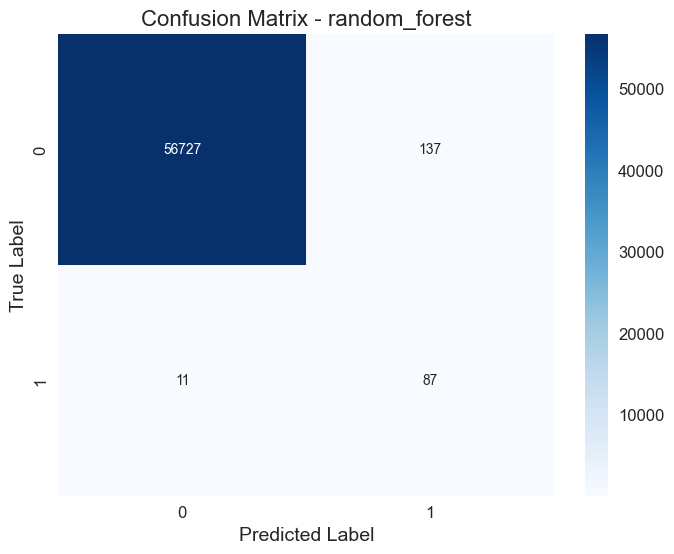

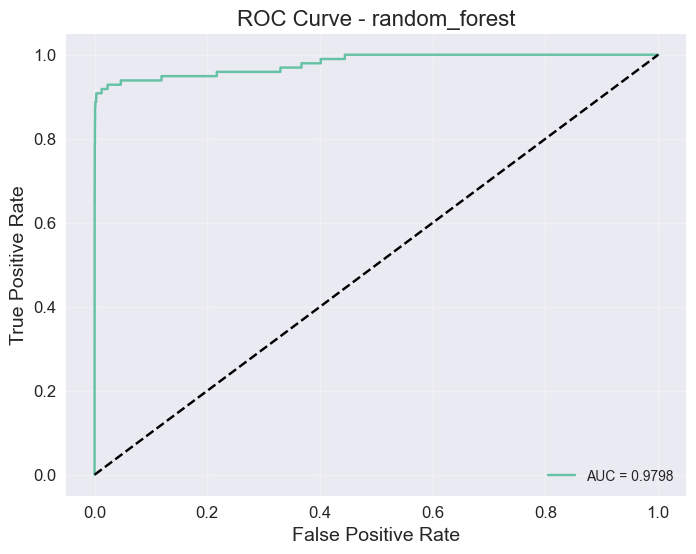

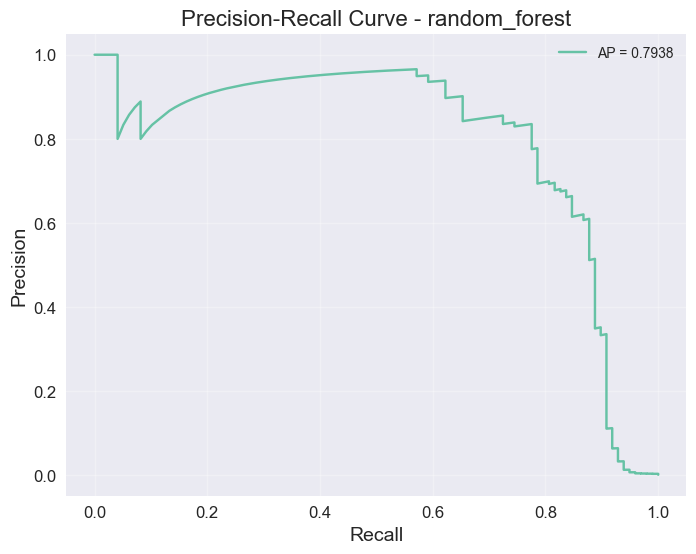



Evaluating xgboost...
Model: xgboost
Prediction time: 0.0300 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.26      0.87      0.40        98

    accuracy                           1.00     56962
   macro avg       0.63      0.93      0.70     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC Score: 0.9802
Average Precision Score: 0.8443


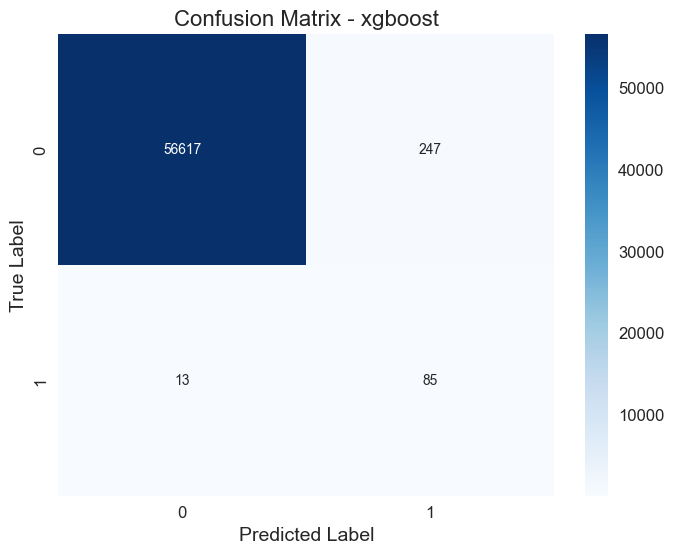

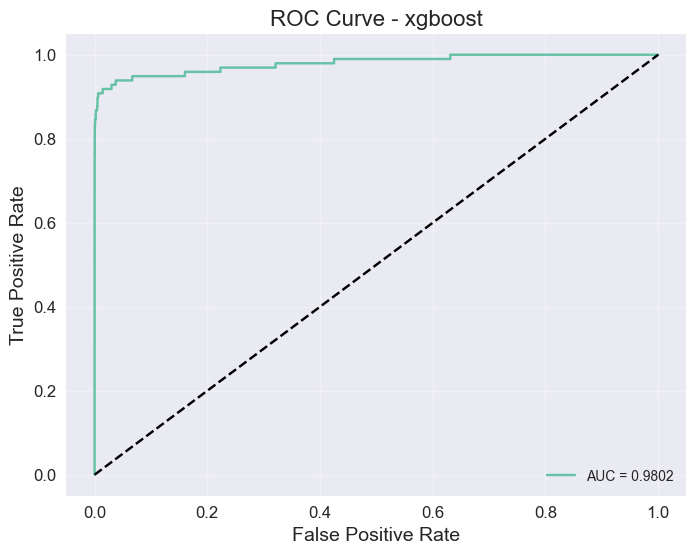

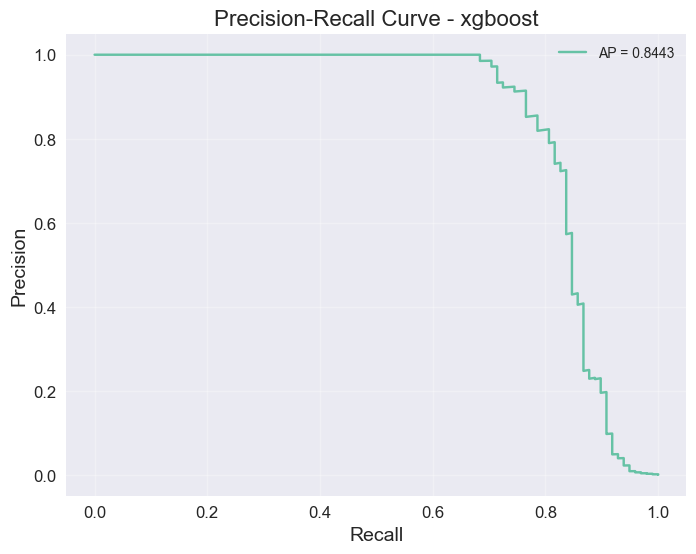



Evaluating gradient_boosting...
Model: gradient_boosting
Prediction time: 0.0155 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.89      0.20        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.60     56962
weighted avg       1.00      0.99      0.99     56962

AUC-ROC Score: 0.9755
Average Precision Score: 0.7642


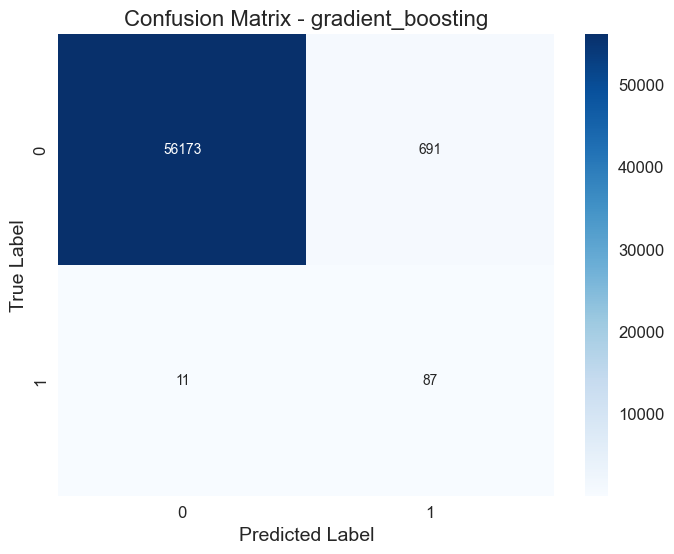

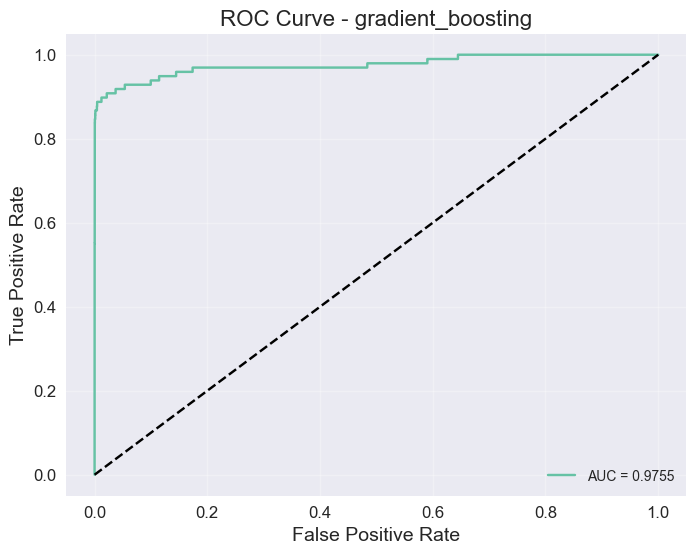

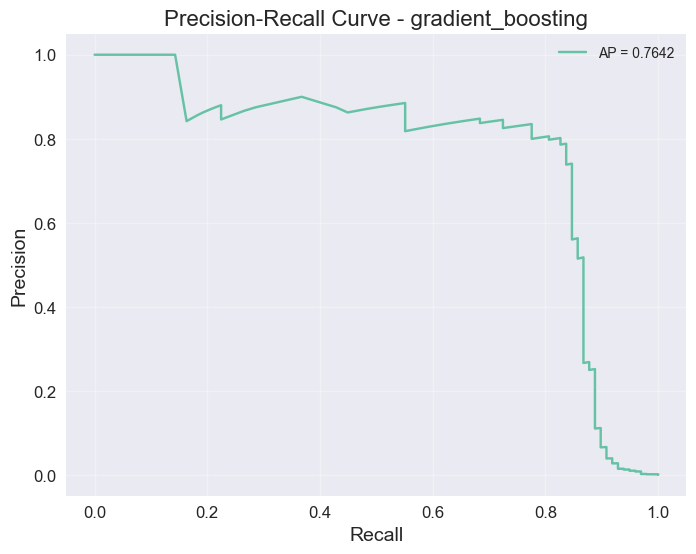

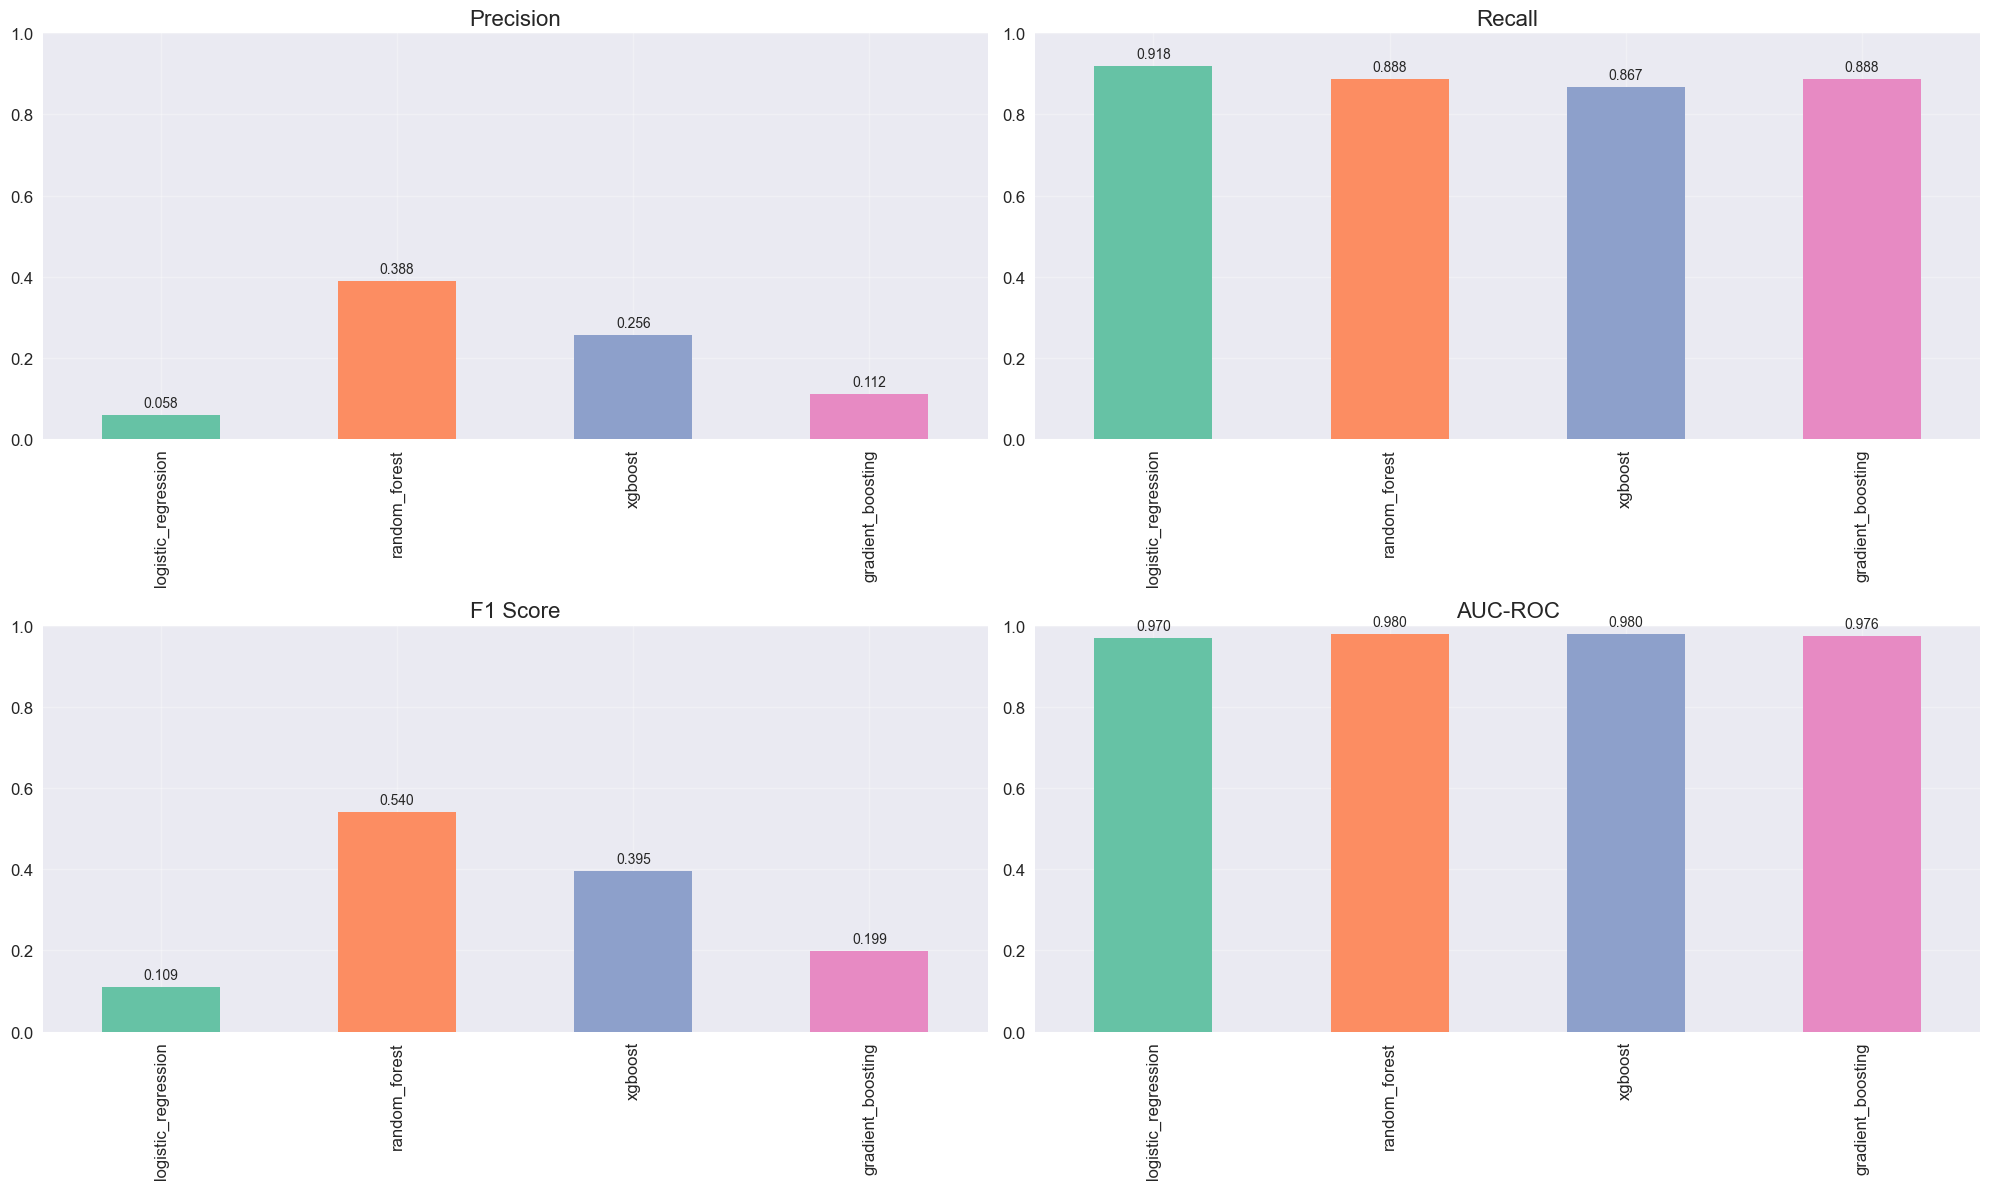

Model Performance Metrics:


In [43]:
# Create and train models - starting with default configurations
models = {
    'logistic_regression': LogisticRegression(**LOGISTIC_REGRESSION_PARAMS),
    'random_forest': RandomForestClassifier(**RANDOM_FOREST_PARAMS),
    'xgboost': xgb.XGBClassifier(**XGBOOST_PARAMS),
    'gradient_boosting': xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='auc',
        random_state=RANDOM_STATE
    )
}

# Train all models on the balanced dataset
print("Training models on SMOTE-balanced data...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Use a subsample for faster training while maintaining class balance
    if name == 'random_forest' or name == 'xgboost':
        # For resource-intensive models, use a smaller balanced dataset
        sample_size = min(50000, len(X_train) // 2)  # Use at most 50k samples
        pos_indices = np.where(y_train == 1)[0]
        neg_indices = np.where(y_train == 0)[0]
        
        # Ensure we maintain the 50/50 balance from SMOTE
        n_each_class = sample_size // 2
        pos_sample = np.random.choice(pos_indices, n_each_class, replace=False)
        neg_sample = np.random.choice(neg_indices, n_each_class, replace=False)
        
        # Combine indices and create the subsample
        indices = np.concatenate([pos_sample, neg_sample])
        X_train_sub = X_train[indices]
        y_train_sub = y_train[indices]
        
        print(f"Training on subsample: {len(X_train_sub):,} samples ({len(X_train_sub)/len(X_train):.1%} of full data)")
        model.fit(X_train_sub, y_train_sub)
    else:
        # For lighter models, use full dataset
        model.fit(X_train, y_train)
        
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")

# Evaluate all models
metrics_dict = {}
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Evaluating {name}...")
    metrics = evaluate_model(model, X_test, y_test, name)
    metrics_dict[name] = metrics
    print(f"{'='*50}\n")

# Compare all models
comparison_df = plot_model_comparison(metrics_dict)

## Model Optimization

Let's optimize the best-performing models using hyperparameter tuning.

Best performing model: xgboost with AUC-ROC of 0.9802
Tuning hyperparameters for xgboost...
Tuning with subsample: 40,000 samples (8.8% of full data)
Starting hyperparameter tuning...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Hyperparameter tuning completed in 2.74 seconds

Best Parameters:
tree_method: hist
subsample: 0.8
n_estimators: 100
min_child_weight: 1
max_depth: 5
learning_rate: 0.1
colsample_bytree: 0.8

Best CV Score: 0.9997
Model: Tuned xgboost
Prediction time: 0.0235 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.23      0.91      0.37        98

    accuracy                           0.99     56962
   macro avg       0.62      0.95      0.68     56962
weighted avg       1.00      0.99      1.00     56962

AUC-ROC Score: 0.9757
Average Precision Score: 0.8002


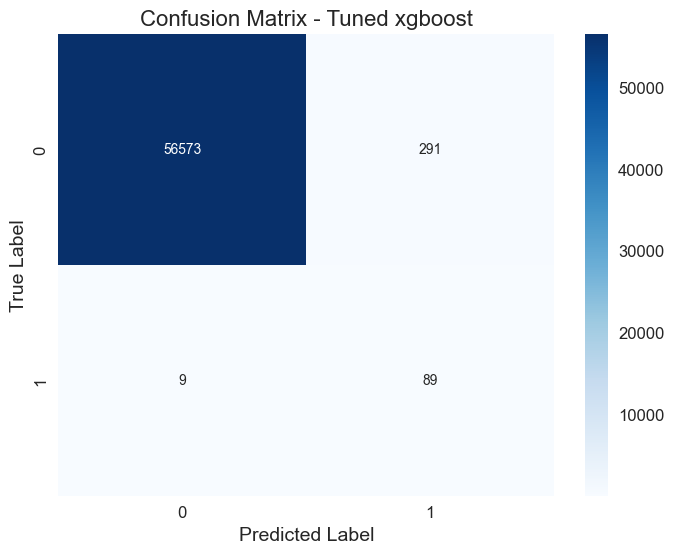

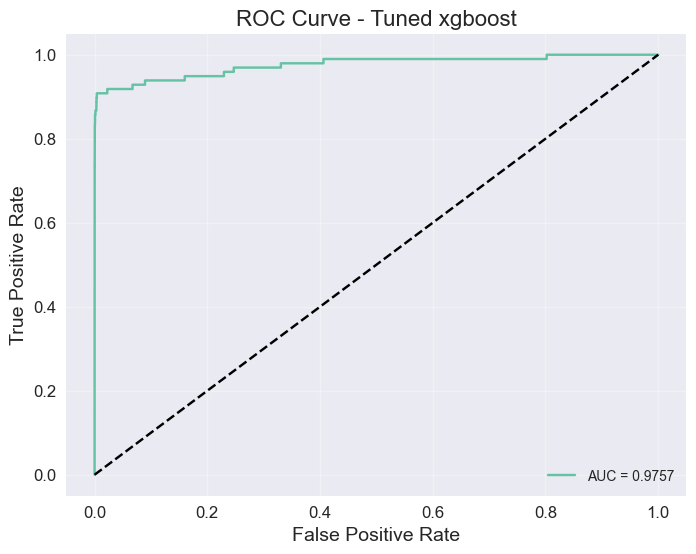

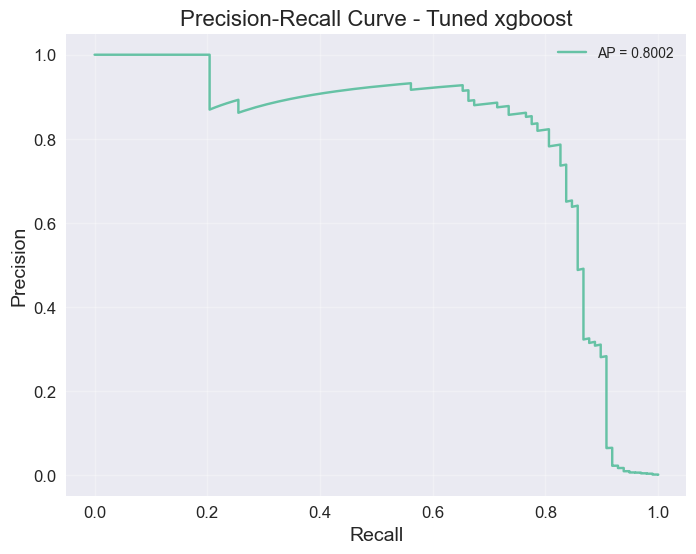

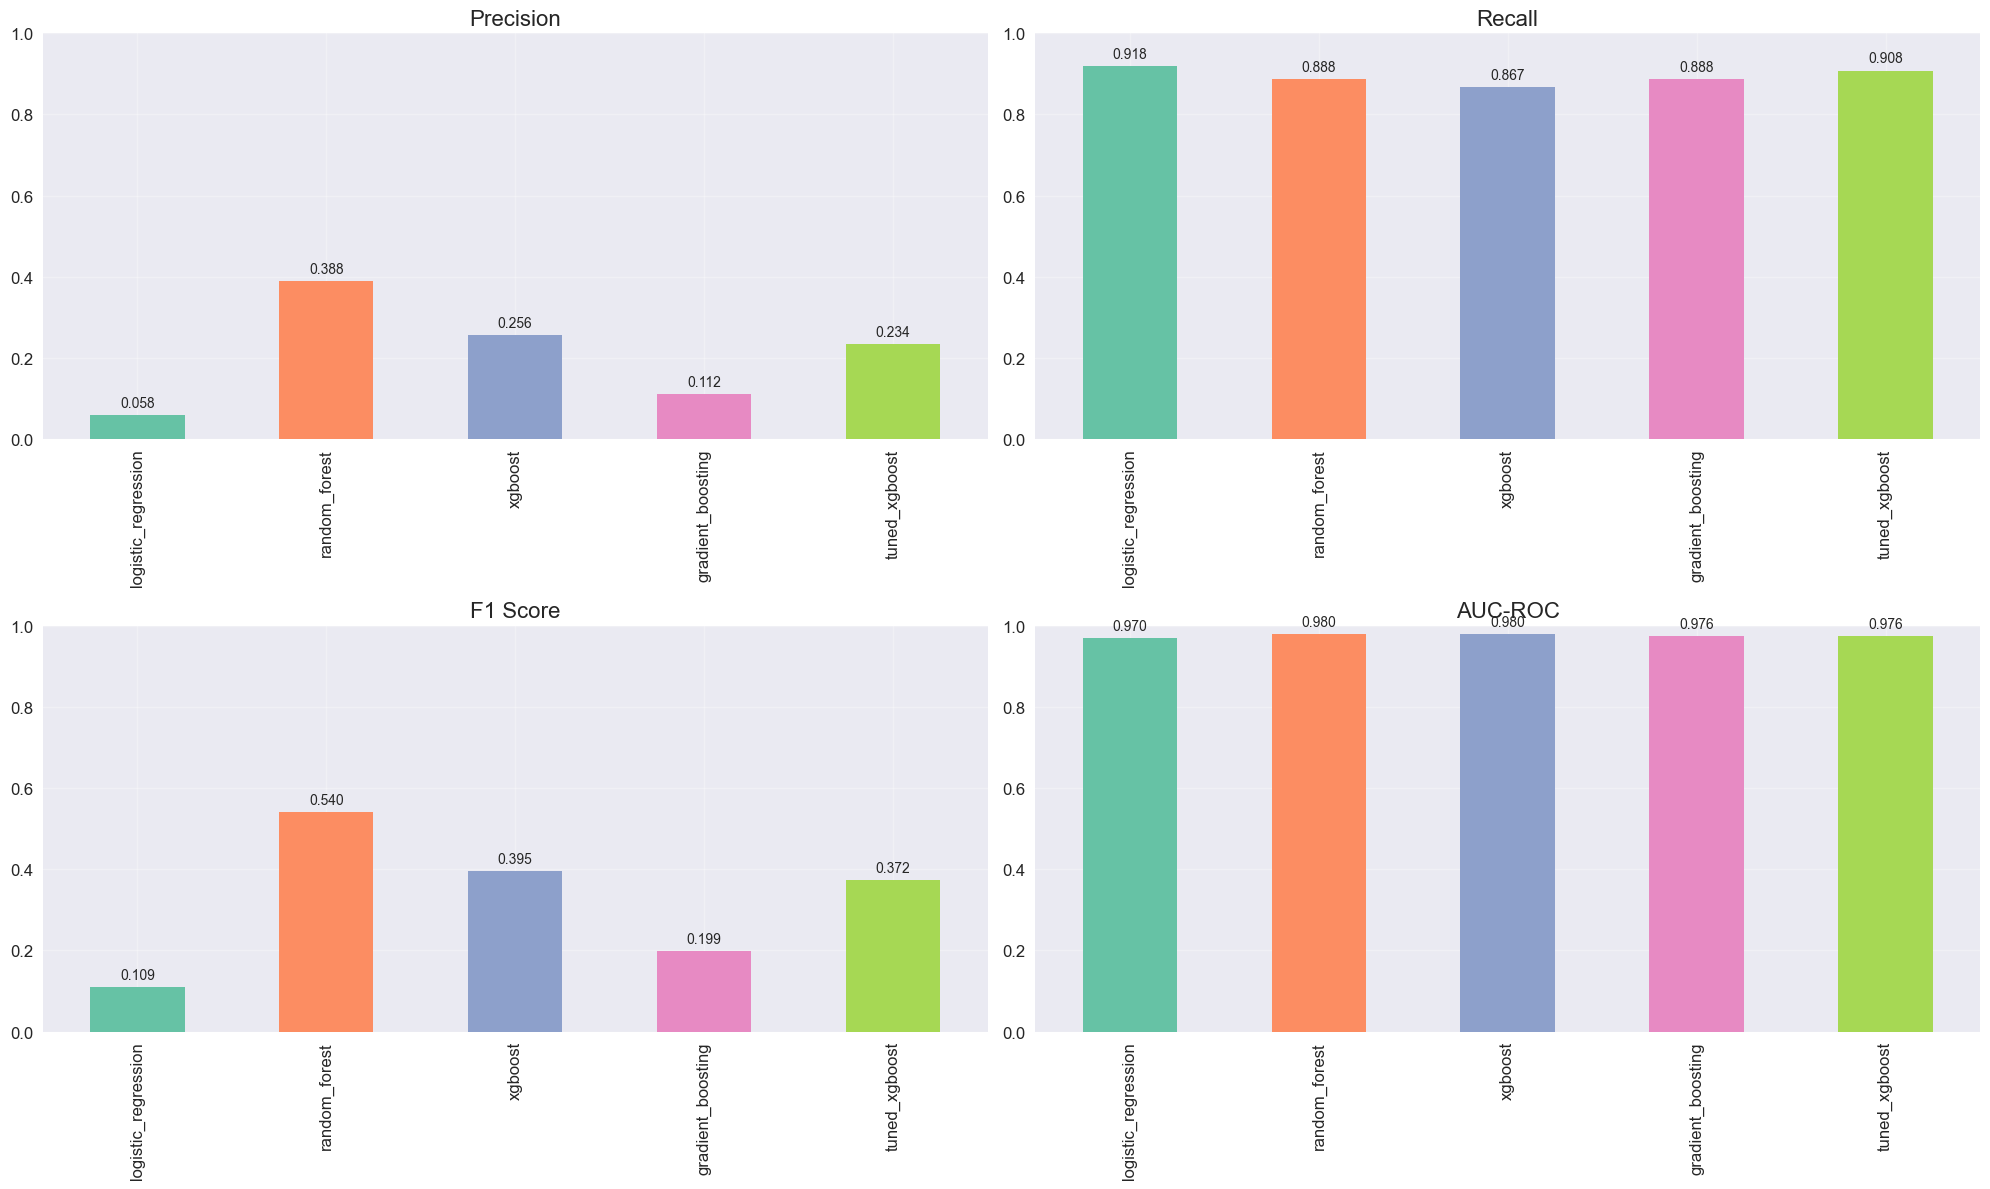

Model Performance Metrics:


In [44]:
# Identify the best performing model based on AUC-ROC
best_model_name = comparison_df['auc_roc'].idxmax()
print(f"Best performing model: {best_model_name} with AUC-ROC of {comparison_df.loc[best_model_name, 'auc_roc']:.4f}")

# Based on the best model identified, tune the appropriate model with a smaller dataset
print(f"Tuning hyperparameters for {best_model_name}...")

# Create a smaller subsample for hyperparameter tuning
sample_size = min(40000, len(X_train) // 2)  # Even smaller for hyperparameter tuning
pos_indices = np.where(y_train == 1)[0]
neg_indices = np.where(y_train == 0)[0]

# Ensure we maintain the balance
n_each_class = sample_size // 2
pos_sample = np.random.choice(pos_indices, n_each_class, replace=False)
neg_sample = np.random.choice(neg_indices, n_each_class, replace=False)

# Combine indices and create the subsample
indices = np.concatenate([pos_sample, neg_sample])
X_train_tune = X_train[indices]
y_train_tune = y_train[indices]

print(f"Tuning with subsample: {len(X_train_tune):,} samples ({len(X_train_tune)/len(X_train):.1%} of full data)")

if best_model_name == "random_forest":
    param_dist = {
        'n_estimators': [50, 100],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
    # Use RandomizedSearchCV to tune Random Forest
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    clf = RandomizedSearchCV(
        estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        param_distributions=param_dist,
        n_iter=8,  # Reduced iterations for faster tuning
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        verbose=1,
        random_state=RANDOM_STATE
    )
elif best_model_name == "xgboost" or best_model_name == "gradient_boosting":
    param_dist = {
        'n_estimators': [50, 100],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'min_child_weight': [1, 3],
        'tree_method': ['hist']  # Use faster histogram algorithm
    }
    # Use RandomizedSearchCV to tune XGBoost
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    clf = RandomizedSearchCV(
        estimator=xgb.XGBClassifier(
            objective='binary:logistic', 
            eval_metric='auc', 
            random_state=RANDOM_STATE,
            n_jobs=-1,
            tree_method='hist'
        ),
        param_distributions=param_dist,
        n_iter=8,  # Reduced iterations for faster tuning
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        verbose=1,
        random_state=RANDOM_STATE
    )
else:
    # Default to a simple model tuning if other model is best
    param_dist = {
        'C': [0.1, 1.0, 10.0],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 200]
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    clf = RandomizedSearchCV(
        estimator=LogisticRegression(random_state=RANDOM_STATE),
        param_distributions=param_dist,
        n_iter=6,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        verbose=1,
        random_state=RANDOM_STATE
    )

# Fit the RandomizedSearchCV with early stopping
print("Starting hyperparameter tuning...")
start_time = time.time()
clf.fit(X_train_tune, y_train_tune)
tuning_time = time.time() - start_time
print(f"Hyperparameter tuning completed in {tuning_time:.2f} seconds")

# Best parameters
print("\nBest Parameters:")
for param, value in clf.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest CV Score: {clf.best_score_:.4f}")

# Evaluate the optimized model
tuned_model = clf.best_estimator_
metrics = evaluate_model(tuned_model, X_test, y_test, f"Tuned {best_model_name}")

# Add to metrics dictionary and compare
metrics_dict[f"tuned_{best_model_name}"] = metrics
comparison_df = plot_model_comparison(metrics_dict)

## Model Interpretation with SHAP

SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explain the output of machine learning models. Let's use it to understand what features are most important for our best model.

Analyzing feature importance for xgboost...


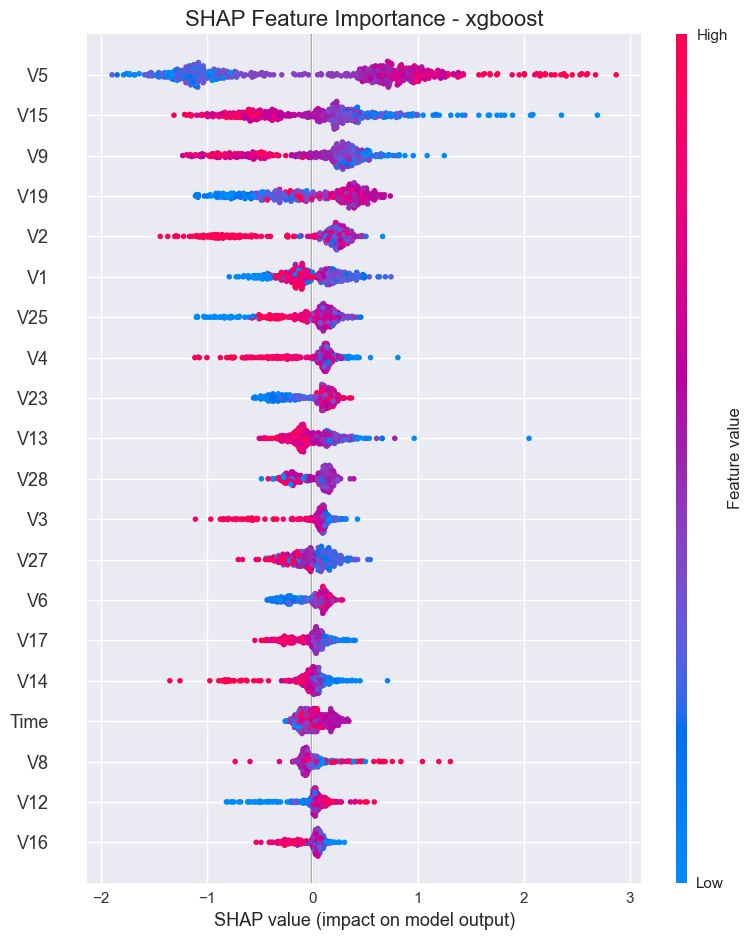

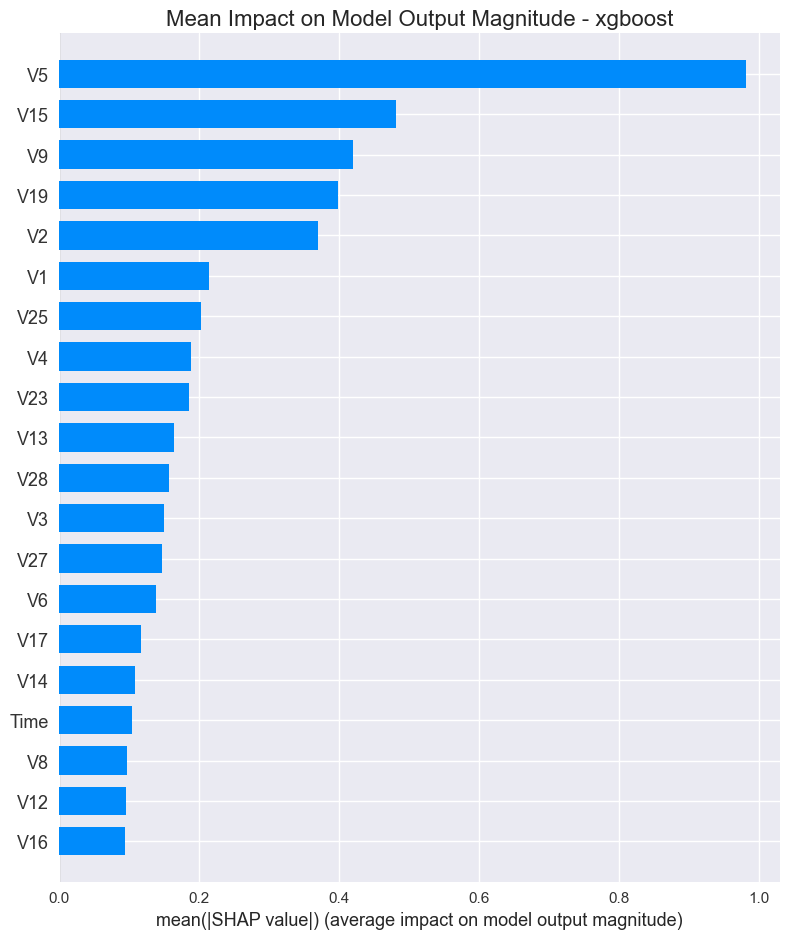


Top 5 Most Important Features:
1. V5 - Mean |SHAP|: 0.9812


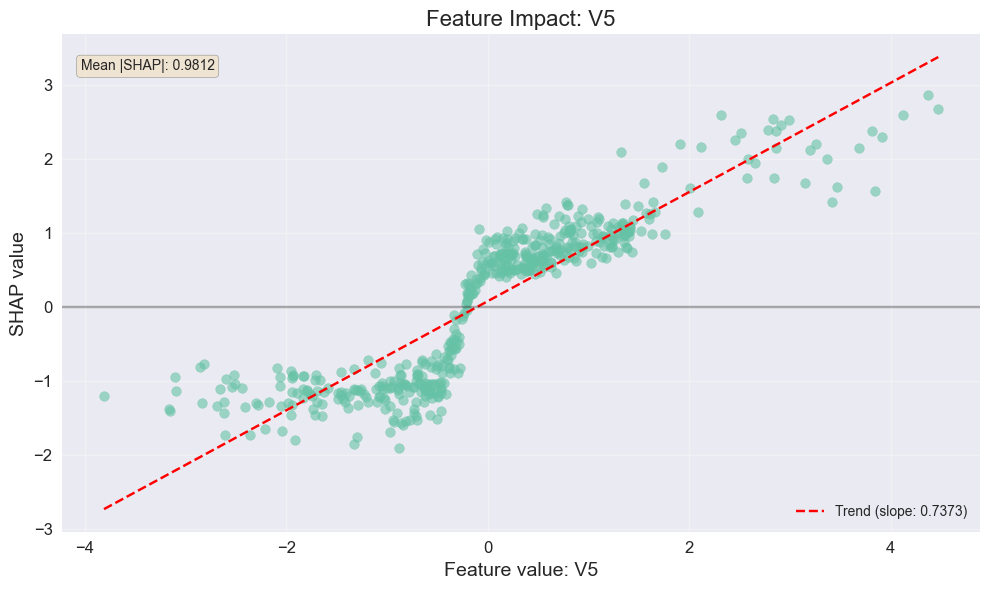

2. V15 - Mean |SHAP|: 0.4816


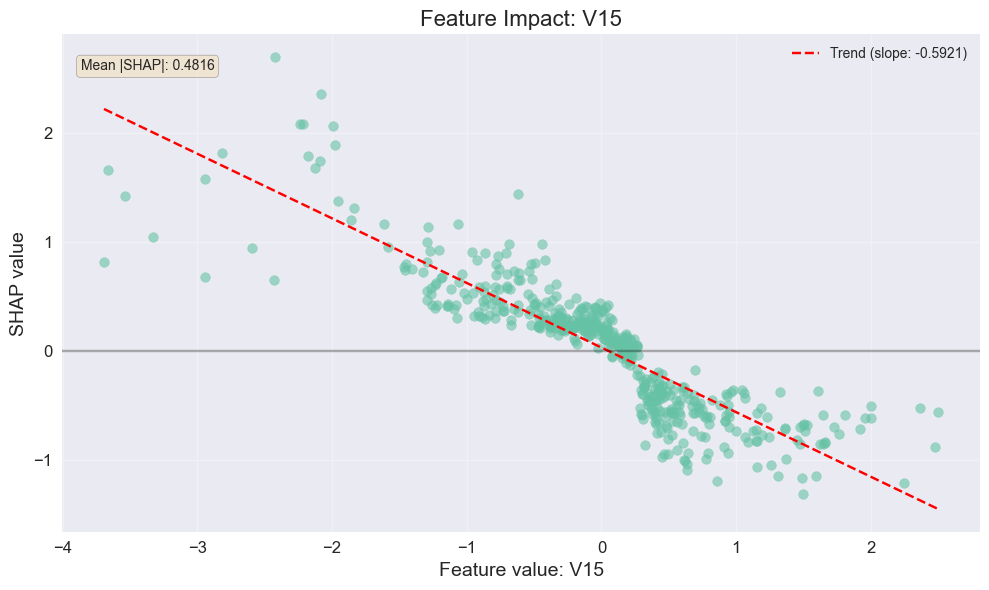

3. V9 - Mean |SHAP|: 0.4198


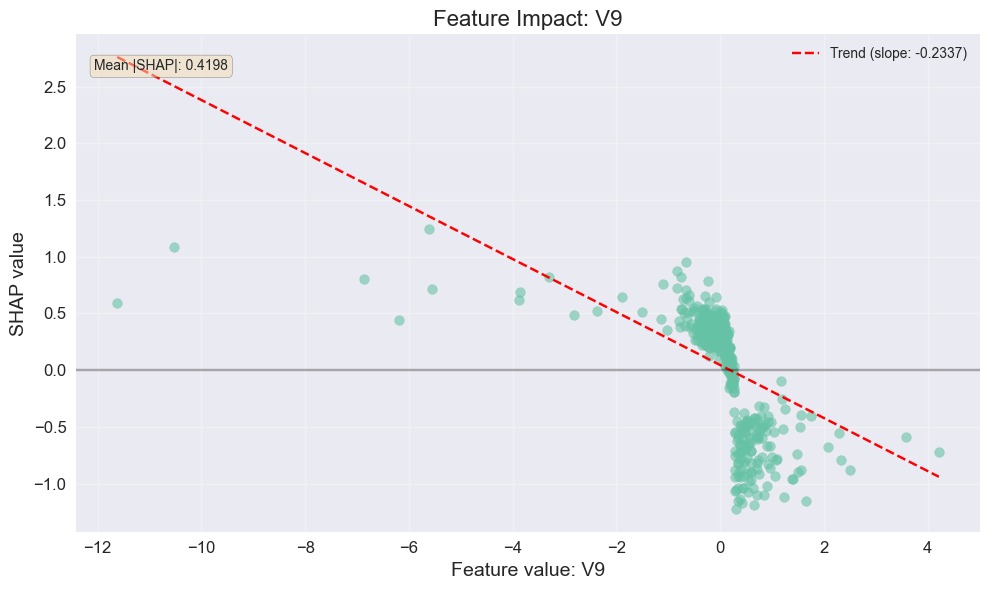

4. V19 - Mean |SHAP|: 0.3979


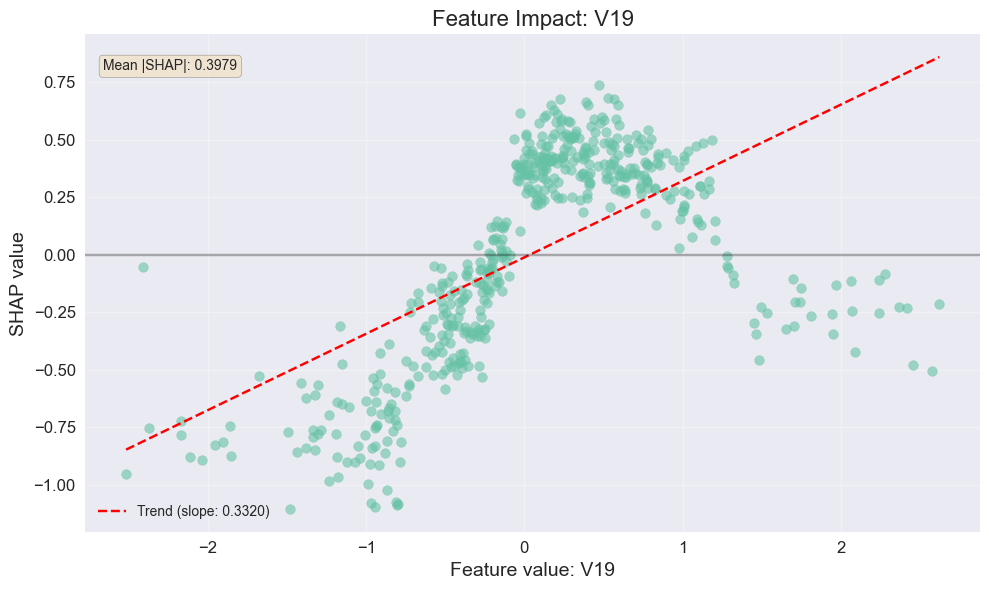

5. V2 - Mean |SHAP|: 0.3703


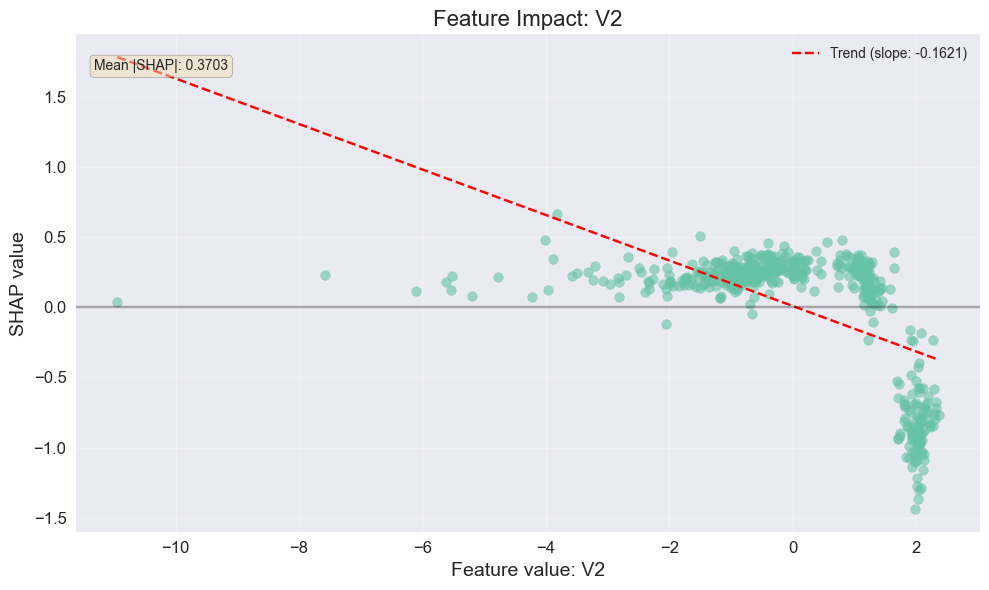

In [48]:
# Get the final best model
final_best_model_name = comparison_df['auc_roc'].idxmax()
final_best_model = models[final_best_model_name] if final_best_model_name in models else tuned_model

print(f"Analyzing feature importance for {final_best_model_name}...")

# Get column names for interpretation
feature_names = [f'V{i}' for i in range(1, 29)] + ['Time', 'Amount']

# Create a small sample for SHAP analysis (for speed)
X_sample = X_test[:500]

# Compute SHAP values
explainer = shap.Explainer(final_best_model, X_sample)
shap_values = explainer(X_sample)

# Plot summary
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
plt.title(f'SHAP Feature Importance - {final_best_model_name}')
plt.tight_layout()
plt.show()

# Plot feature importance by mean absolute SHAP value
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type='bar', show=False)
plt.title(f'Mean Impact on Model Output Magnitude - {final_best_model_name}')
plt.tight_layout()
plt.show()

# Get top 5 features by mean absolute SHAP value
mean_abs_shap = np.abs(shap_values.values).mean(0)
top_features_idx = np.argsort(mean_abs_shap)[-5:][::-1]  # Get indices of top 5 features
top_features_idx = top_features_idx.flatten()

top_features = []
for i in top_features_idx:
    top_features.append(feature_names[int(i)])  # Convert index to integer

print("\nTop 5 Most Important Features:")
for i, feature in enumerate(top_features):
    feature_idx = int(top_features_idx[i])  # Get the integer index
    # Handle NumPy arrays of any dimension by taking the mean
    shap_value_arr = mean_abs_shap[feature_idx]
    if hasattr(shap_value_arr, 'shape') and shap_value_arr.size > 1:
        shap_value = float(shap_value_arr.mean())  # Average all values in array
    else:
        shap_value = float(shap_value_arr)  # Direct conversion for scalars
    print(f"{i+1}. {feature} - Mean |SHAP|: {shap_value:.4f}")
    
    # Create a custom scatter plot instead of dependence plot to avoid dimension mismatch
    plt.figure(figsize=(10, 6))
    feature_idx_pos = feature_names.index(feature)
    
    # Get feature values and corresponding SHAP values
    feature_values = X_sample[:, feature_idx_pos]
    
    # Handle multi-dimensional SHAP values if needed
    if len(shap_values.values.shape) > 2:
        # For multi-output models, take mean across outputs
        feature_shap_values = np.mean(shap_values.values[:, feature_idx_pos], axis=1)
    else:
        feature_shap_values = shap_values.values[:, feature_idx_pos]
    
    # Create scatter plot of feature values vs SHAP values
    plt.scatter(feature_values, feature_shap_values, alpha=0.6)
    plt.xlabel(f'Feature value: {feature}')
    plt.ylabel('SHAP value')
    plt.title(f'Feature Impact: {feature}')
    
    # Add a trend line
    z = np.polyfit(feature_values, feature_shap_values, 1)
    p = np.poly1d(z)
    plt.plot(np.sort(feature_values), p(np.sort(feature_values)), 
             'r--', label=f'Trend (slope: {z[0]:.4f})')
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Add context about feature importance
    plt.text(0.02, 0.95, f'Mean |SHAP|: {shap_value:.4f}', 
             transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Threshold Optimization

For fraud detection, the default threshold of 0.5 may not be optimal. Let's find the best threshold based on our business needs. Typically in fraud detection, we prioritize recall to minimize missed fraud cases, but we also need to maintain reasonable precision to avoid too many false positives.

Evaluating model with different thresholds:

Default (0.5) (Threshold = 0.5000):
Precision: 0.2560
Recall: 0.8673
F1 Score: 0.3953

F1 Optimal (Threshold = 0.9959):
Precision: 0.9146
Recall: 0.7653
F1 Score: 0.8333

F2 Optimal (Threshold = 0.9569):
Precision: 0.7257
Recall: 0.8367
F1 Score: 0.7773

Recall+Precision Optimal (Threshold = 0.9980):
Precision: 0.9857
Recall: 0.7041
F1 Score: 0.8214


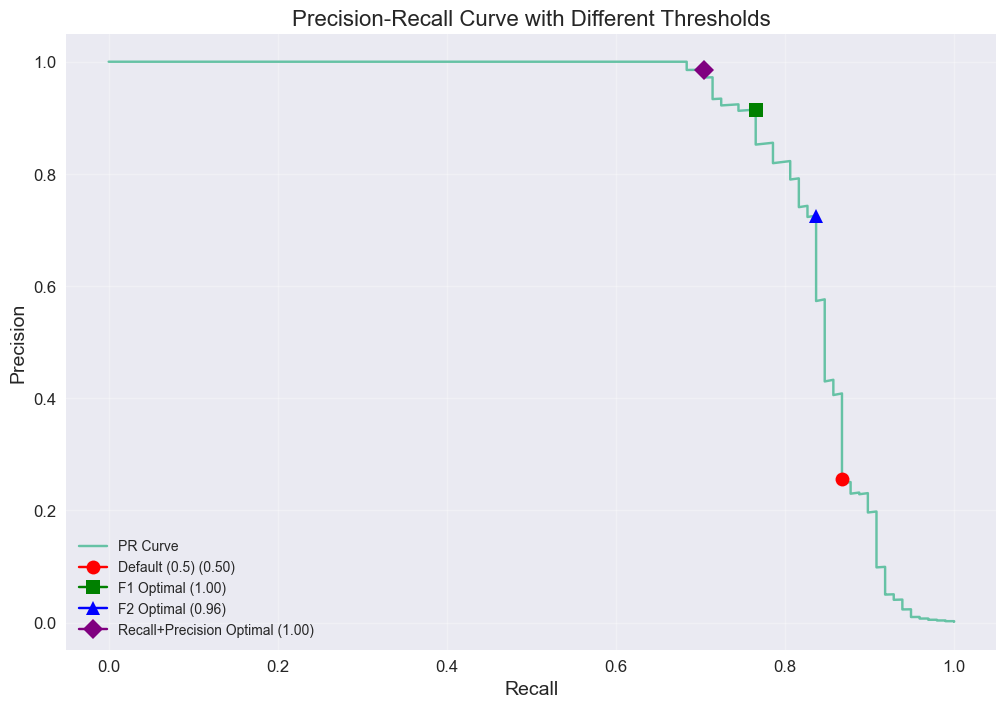

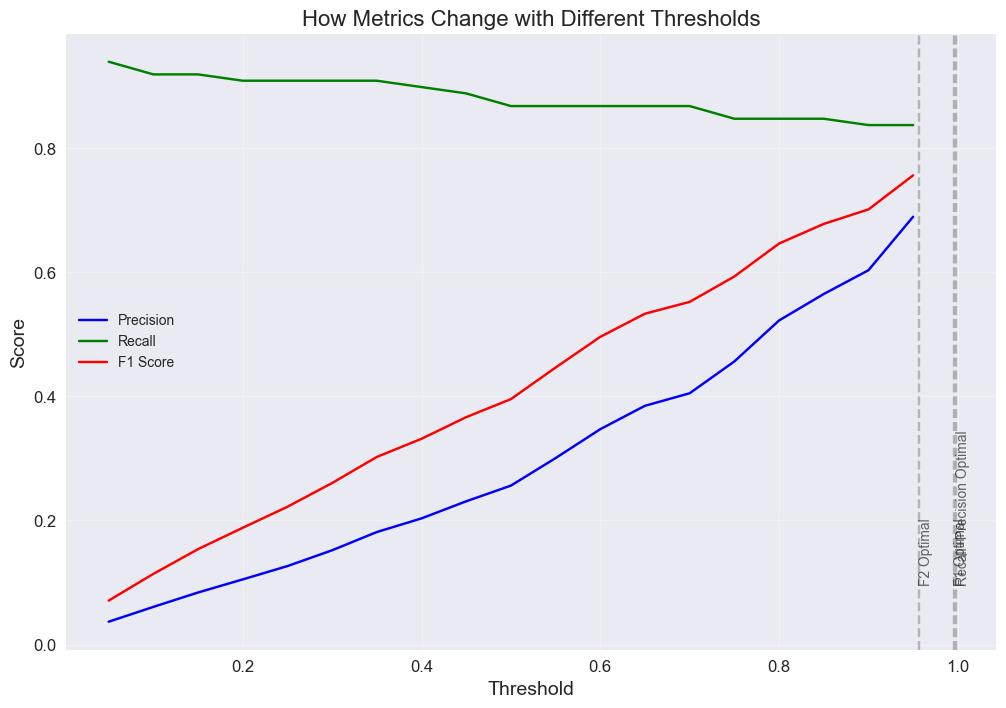


Recommended threshold for deployment: 0.9569
This threshold provides a balance with:
Precision: 0.7257
Recall: 0.8367
F1 Score: 0.7773


In [49]:
# Get predicted probabilities from the best model
best_model = final_best_model
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall for different thresholds
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_pred_proba)
thresholds = np.append(thresholds, 1.0)  # Add 1.0 to thresholds for alignment with precision/recall

# Calculate F1 score for each threshold
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-8)

# Calculate F2 score (weights recall higher than precision) for each threshold
beta = 2  # F2 score weights recall higher than precision
f2_scores = (1 + beta**2) * (precision_curve * recall_curve) / ((beta**2 * precision_curve) + recall_curve + 1e-8)

# Get optimal thresholds for different metrics
max_f1_idx = np.argmax(f1_scores)
max_f2_idx = np.argmax(f2_scores)
max_recall_precision_idx = np.argmax(precision_curve + recall_curve)  # Simple sum optimization

optimal_thresholds = {
    'F1 Score': thresholds[max_f1_idx],
    'F2 Score': thresholds[max_f2_idx],
    'Recall+Precision': thresholds[max_recall_precision_idx]
}

# Function to evaluate with a custom threshold
def evaluate_with_threshold(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba >= threshold).astype(int)
    return {
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'threshold': threshold
    }

# Evaluate model with different thresholds
print("Evaluating model with different thresholds:")
thresholds_to_evaluate = {
    'Default (0.5)': 0.5,
    'F1 Optimal': optimal_thresholds['F1 Score'],
    'F2 Optimal': optimal_thresholds['F2 Score'],
    'Recall+Precision Optimal': optimal_thresholds['Recall+Precision']
}

threshold_metrics = {}
for name, threshold in thresholds_to_evaluate.items():
    metrics = evaluate_with_threshold(y_test, y_pred_proba, threshold)
    threshold_metrics[name] = metrics
    print(f"\n{name} (Threshold = {threshold:.4f}):")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")

# Plot precision-recall curve with thresholds
plt.figure(figsize=(12, 8))
plt.plot(recall_curve, precision_curve, label='PR Curve')

# Mark optimal points
colors = ['red', 'green', 'blue', 'purple']
markers = ['o', 's', '^', 'D']
for i, (name, threshold) in enumerate(thresholds_to_evaluate.items()):
    # Find closest threshold in our list
    closest_idx = np.argmin(np.abs(thresholds - threshold))
    plt.plot(recall_curve[closest_idx], precision_curve[closest_idx], 
             marker=markers[i], markersize=10, color=colors[i], 
             label=f'{name} ({threshold:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Different Thresholds')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# Plot threshold vs metrics
thresholds_range = np.linspace(0.05, 0.95, 19)
metrics_by_threshold = [evaluate_with_threshold(y_test, y_pred_proba, t) for t in thresholds_range]
metrics_df = pd.DataFrame(metrics_by_threshold)

plt.figure(figsize=(12, 8))
plt.plot(thresholds_range, metrics_df['precision'], 'b-', label='Precision')
plt.plot(thresholds_range, metrics_df['recall'], 'g-', label='Recall')
plt.plot(thresholds_range, metrics_df['f1'], 'r-', label='F1 Score')

for name, threshold in thresholds_to_evaluate.items():
    if name != 'Default (0.5)':  # Skip default to avoid cluttering
        plt.axvline(x=threshold, linestyle='--', color='gray', alpha=0.5)
        plt.text(threshold, 0.1, name, rotation=90, alpha=0.7)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('How Metrics Change with Different Thresholds')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# Choose the best threshold based on our priorities for fraud detection
# For fraud detection, we typically prioritize recall (catching frauds)
# while maintaining acceptable precision (avoiding too many false alarms)
best_threshold_name = 'F2 Optimal'  # This weights recall higher
best_threshold = thresholds_to_evaluate[best_threshold_name]
best_threshold_metrics = threshold_metrics[best_threshold_name]

print(f"\nRecommended threshold for deployment: {best_threshold:.4f}")
print(f"This threshold provides a balance with:")
print(f"Precision: {best_threshold_metrics['precision']:.4f}")
print(f"Recall: {best_threshold_metrics['recall']:.4f}")
print(f"F1 Score: {best_threshold_metrics['f1']:.4f}")

## Save Final Model

Now that we've identified the best model and threshold, let's save it for deployment.

In [50]:
# Create a final model dict with metadata for deployment
final_model_info = {
    'model': best_model,
    'model_name': final_best_model_name,
    'threshold': best_threshold,
    'metrics': best_threshold_metrics,
    'feature_names': feature_names,
    'training_date': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
}

# Add top features if they exist
if 'top_features' in locals():
    final_model_info['top_features'] = top_features

# Ensure models directory exists
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Save the model
best_model_path = MODELS_DIR / "best_model.joblib"
joblib.dump(best_model, best_model_path)

# Save metadata
metadata_path = MODELS_DIR / "model_metadata.joblib"
model_metadata = {k: v for k, v in final_model_info.items() if k != 'model'}
joblib.dump(model_metadata, metadata_path)

print(f"Final model saved at: {best_model_path}")
print(f"Model metadata saved at: {metadata_path}")

# Test loading the model
loaded_model = joblib.load(best_model_path)
loaded_metadata = joblib.load(metadata_path)

# Verify loaded model works as expected
test_pred_proba = loaded_model.predict_proba(X_test[:5])[:, 1]
test_pred = (test_pred_proba >= loaded_metadata['threshold']).astype(int)

print("\nVerification of loaded model:")
print(f"Predictions for the first 5 test samples: {test_pred}")
print(f"Prediction probabilities: {test_pred_proba}")
print(f"Threshold: {loaded_metadata['threshold']}")

if 'top_features' in loaded_metadata:
    print(f"Feature importance: Top features are {', '.join(loaded_metadata['top_features'])}")

print("\nModel training and selection complete! The best model is ready for deployment.")

Final model saved at: /Users/sebastian/Improvement/ai/fraud_detection_with_machine_learning/notebooks/../models/best_model.joblib
Model metadata saved at: /Users/sebastian/Improvement/ai/fraud_detection_with_machine_learning/notebooks/../models/model_metadata.joblib

Verification of loaded model:
Predictions for the first 5 test samples: [0 0 0 0 0]
Prediction probabilities: [0.00067061 0.0001297  0.00263589 0.00027558 0.00719532]
Threshold: 0.9568895101547241
Feature importance: Top features are V5, V15, V9, V19, V2

Model training and selection complete! The best model is ready for deployment.
